## Import Toolkit

In [4]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
train_data_path = '/kaggle/input/brain-tumor-mri-dataset/Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [6]:
train_df

,filepaths,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [7]:
test_data_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [8]:
test_df

,filepaths,label
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


## Split Data into Valid and Test

In [9]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

## Image Data Generator

In [10]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Show sample from train data

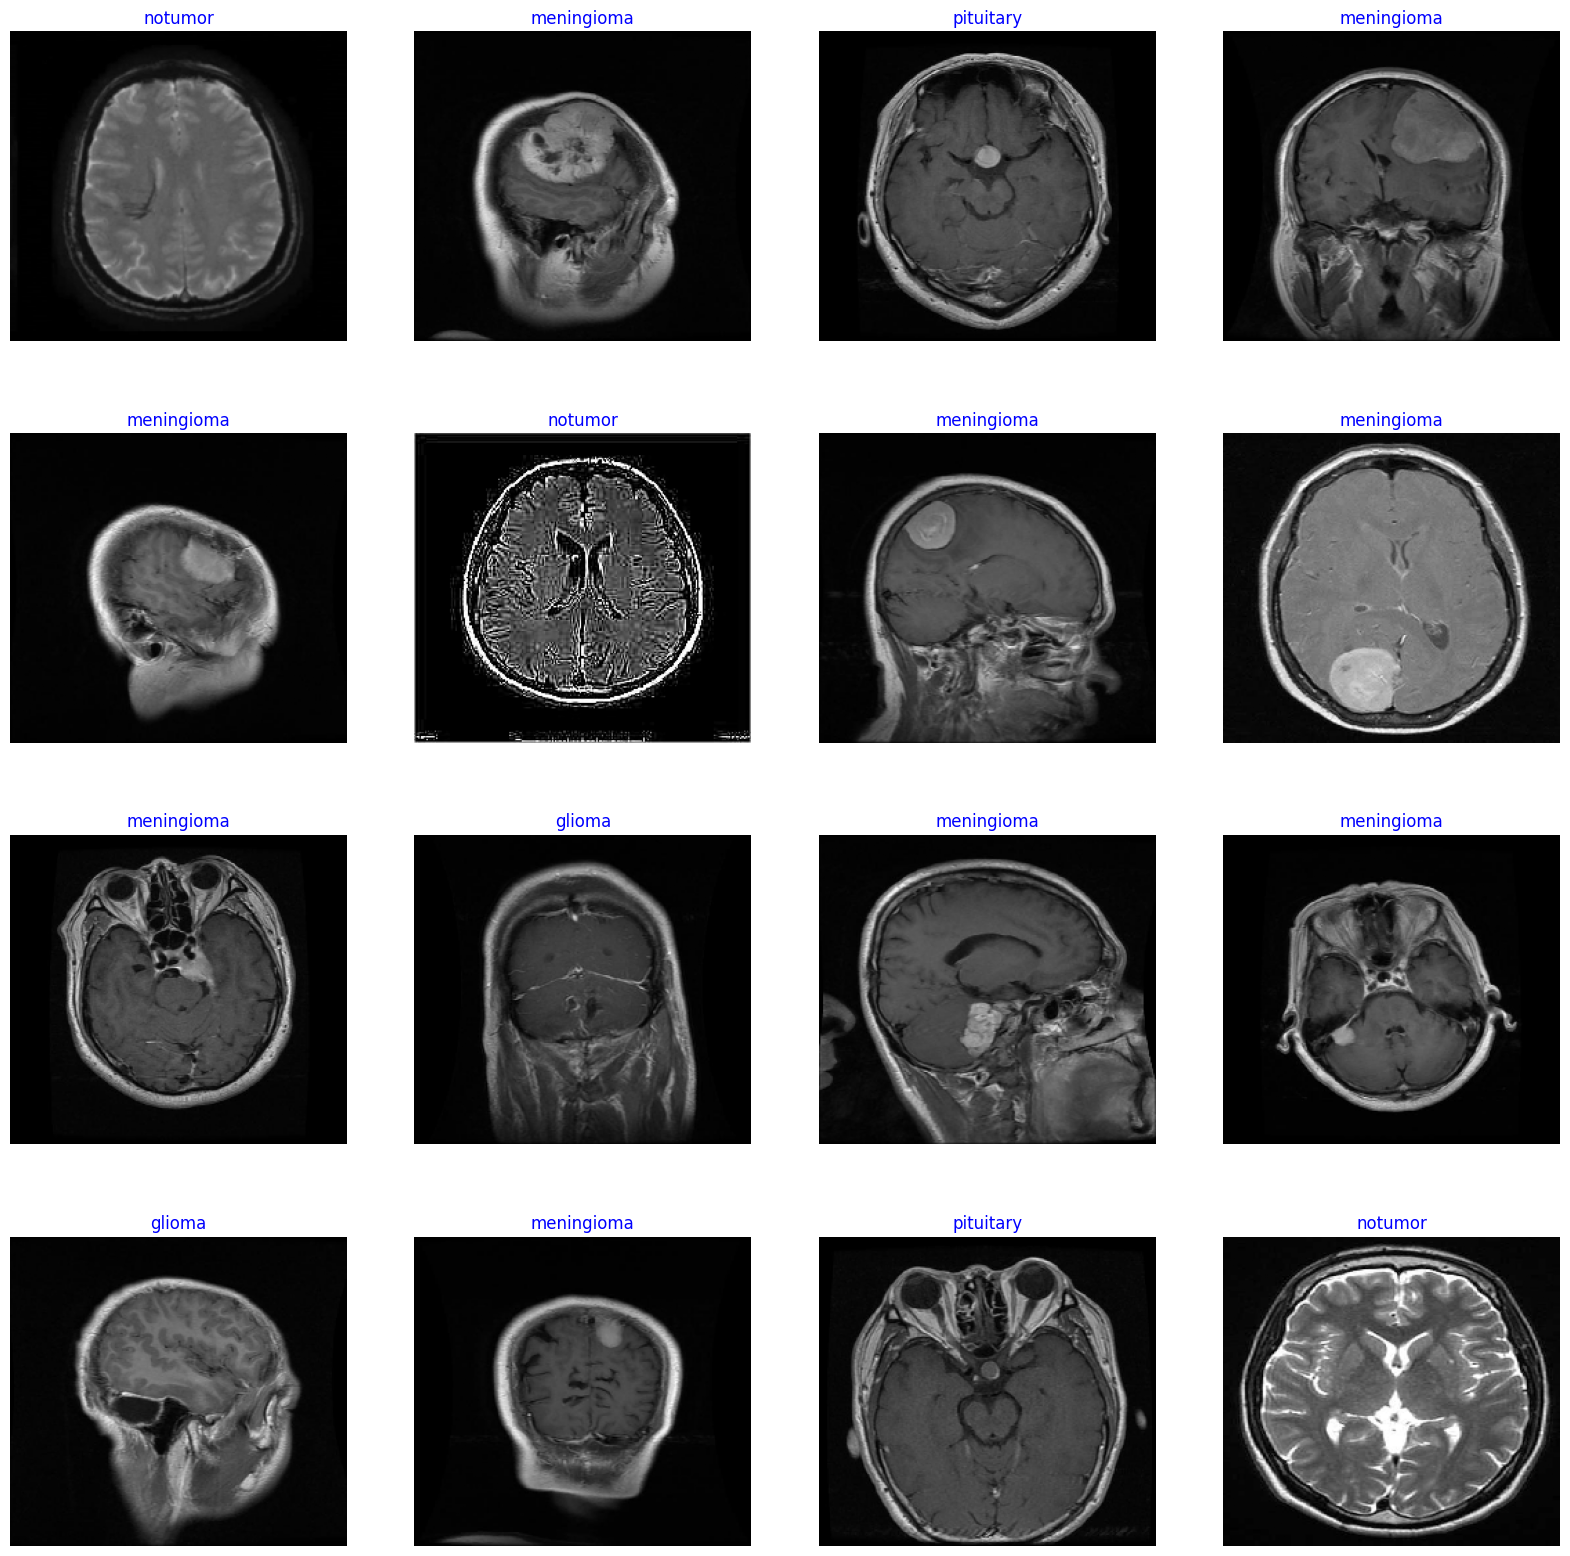

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## Model 

In [12]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non

## Iterate

In [14]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10
357/357 [==============================] - 84s 235ms/step - loss: 2.4609 - accuracy: 0.9641 - val_loss: 1.6115 - val_accuracy: 0.9893
Epoch 2/10
357/357 [==============================] - 82s 229ms/step - loss: 1.1956 - accuracy: 0.9767 - val_loss: 0.7713 - val_accuracy: 0.9939
Epoch 3/10
357/357 [==============================] - 82s 229ms/step - loss: 0.6154 - accuracy: 0.9834 - val_loss: 0.4318 - val_accuracy: 0.9893
Epoch 4/10
357/357 [==============================] - 82s 230ms/step - loss: 0.3667 - accuracy: 0.9876 - val_loss: 0.2612 - val_accuracy: 0.9954
Epoch 5/10
357/357 [==============================] - 82s 229ms/step - loss: 0.2533 - accuracy: 0.9902 - val_loss: 0.2138 - val_accuracy: 0.9893
Epoch 6/10
357/357 [==============================] - 82s 230ms/step - loss: 0.1984 - accuracy: 0.9933 - val_loss: 0.1725 - val_accuracy: 0.9908
Epoch 7/10
357/357 [==============================] - 82s 229ms/step - loss: 0.1758 - accuracy: 0.9939 - val_loss: 0.1781 - val_ac

## Model Performance

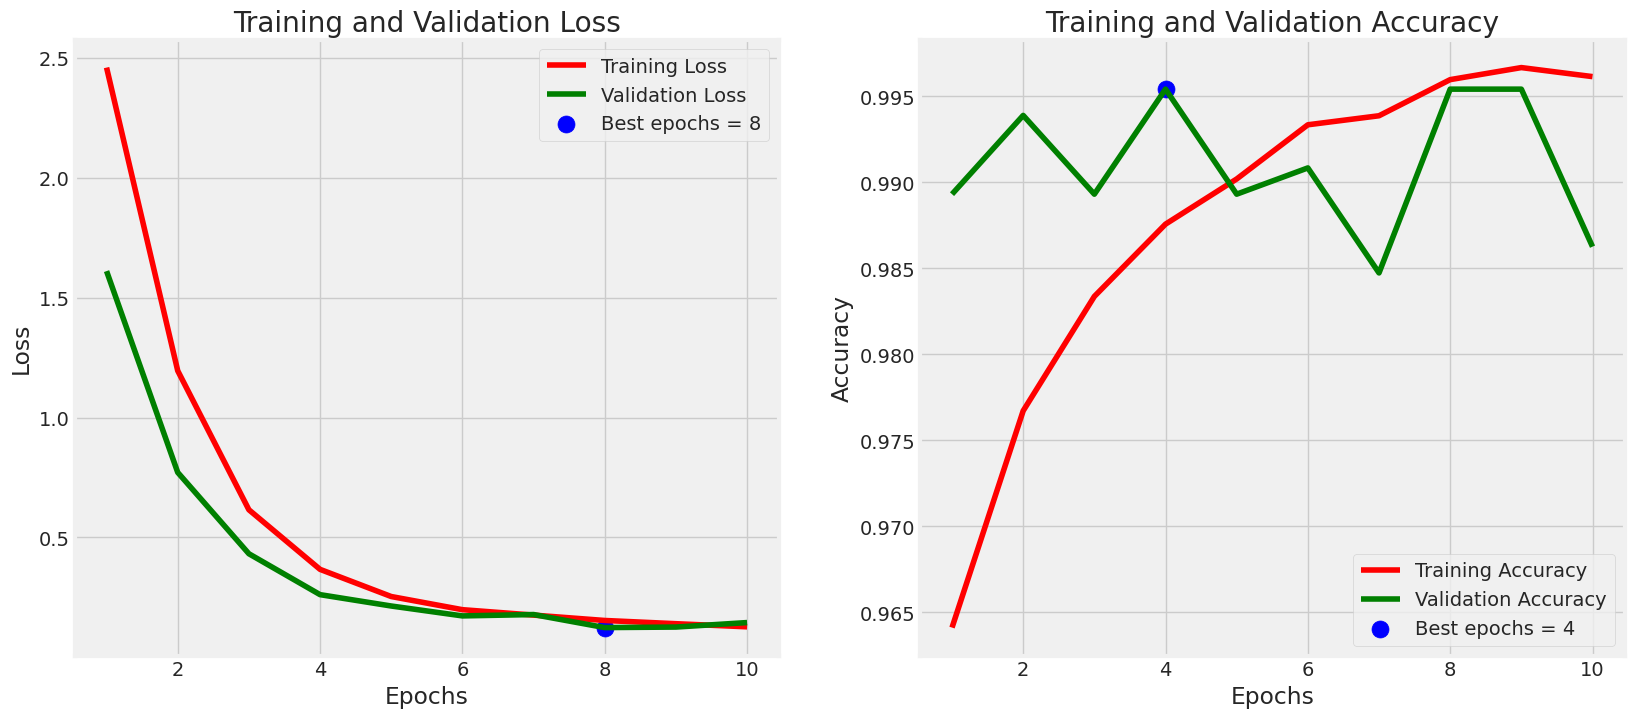

In [15]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

## Model Evaluation

In [16]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 2s 134ms/step - loss: 0.1706 - accuracy: 0.9844
Train Loss:  0.10205937176942825
Train Accuracy:  1.0
--------------------
Validation Loss:  0.17595218122005463
Validation Accuracy:  0.9765625
--------------------
Test Loss:  0.17056527733802795
Test Accuracy:  0.984375


## Model Prediction

## Confusion Matrix and Classification Report

In [17]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

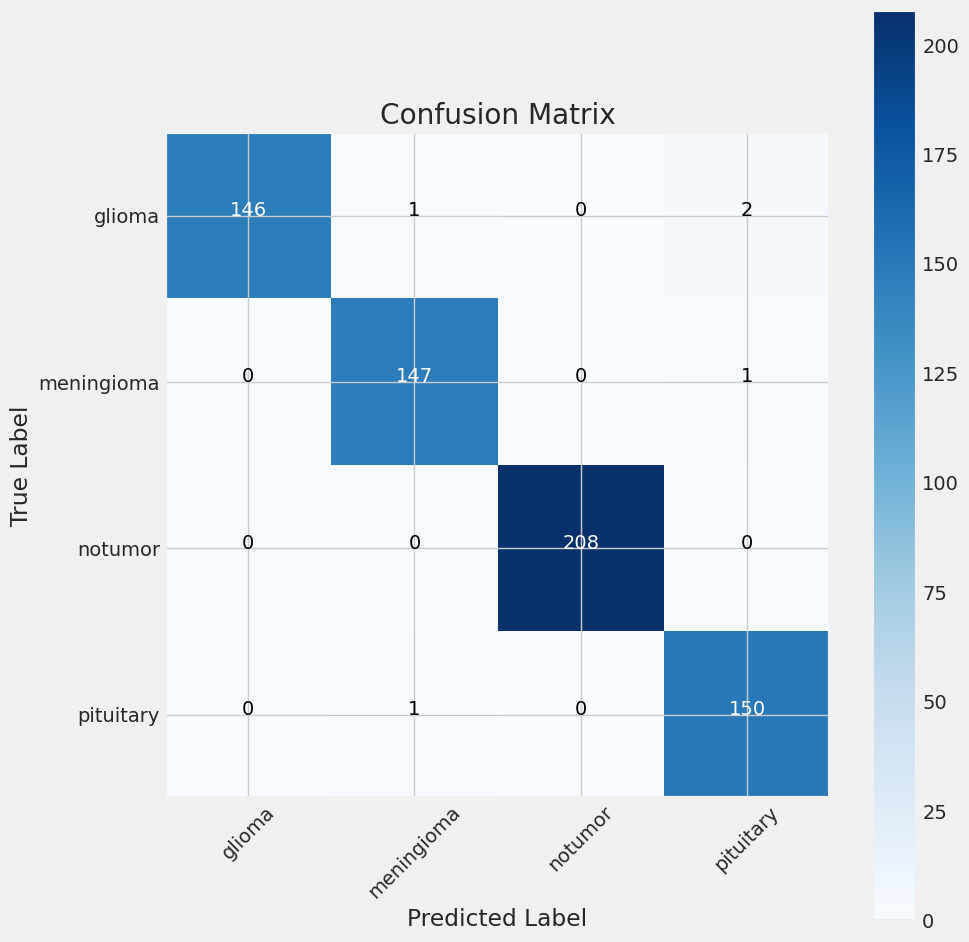

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       149
  meningioma       0.99      0.99      0.99       148
     notumor       1.00      1.00      1.00       208
   pituitary       0.98      0.99      0.99       151

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656

